# Supervised Machine Learning 2: More on Classification and Regression

This notebook builds on the previous lecture through additional examples of *supervised learning* problems, where the game is to learn a relationship between input variables (features) and an output variable (target). Recall there are two basic types of supervised learning problems: *classification*, where the target is a categorical variable (e.g., a color) and *regresssion*, where the target is a floating point number (e.g., the GDP of Scotland). 

Some of the examples in this notebook are modified from the book Introduction to Machine Learning with Python by Müller and Guido:

* https://www.oreilly.com/library/view/introduction-to-machine/9781449369880/

In [1]:
# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib.colors import ListedColormap

# scikit-learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

# seaborn for plotting
import seaborn as sns; sns.set()

## Logistic Regression 

Despite its name, logistic regression is really a *classification* algorithm and not a *regression* algorithm. Logistic regression solves for numerical coefficients to define a linear decision boundary used to classify data.

Mathematically, the setup is:

\begin{equation}
\log \left( \frac{P}{1-P} \right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ...
\end{equation}

where $P$ is the probability the target $y$ is of some class or category. Essentially, we are doing linear regression after a logistic transformation (or linear regression the "log odds"). Hence the name, "logistic regression".

Logistic regression can in principle be applied to multidimensional data, but here we'll focus on the simple two-class case.

### Generate a dataset that we'll be classifying 


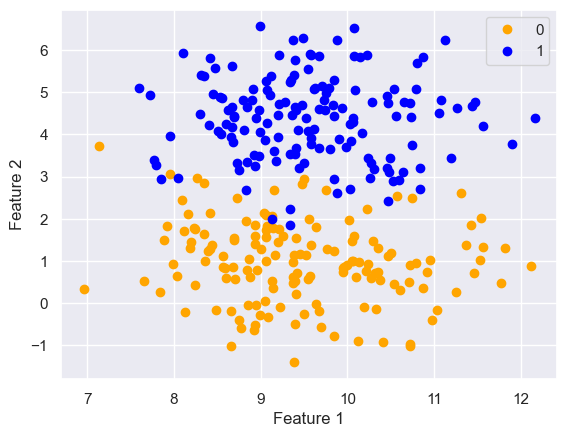

In [2]:
# Generate the dataset
X, y = make_blobs(centers=2, random_state=4, n_samples=300)

# Plot the dataset
k0 = y == 0
k1 = y == 1
plt.plot(X[k0,0], X[k0,1], 'o', color='orange', label='0')
plt.plot(X[k1,0], X[k1,1], 'o', color='blue', label='1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best');

### Logistic Regression Model

In [3]:
# Divide into training and testing (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [4]:
# Fit model
model_lr = LogisticRegression(solver='liblinear')   # instantiate model, there are several solvers
ymodel = model_lr.fit(X_train, y_train).predict(X)  # fit training data, predict for all points

From the model coefficients, we can recover the "decision boundary", the line that seperates the two classes. For our 2D case (with features $x_1$ and $x_2$), the logistic regression problem is:

\begin{equation}
\log \left( \frac{P}{1-P} \right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2
\end{equation}

Along the decision line, $P = 0.5$ (equal class probabilities), so the formula is:

\begin{equation}
x_2 = -\frac{\beta_0}{\beta_2} - {\frac{\beta_1}{\beta_2}} x_1
\end{equation}

In [5]:
# Calculate decision boundary
b0 = model_lr.intercept_[0] # coeff 0
b1, b2 = model_lr.coef_[0] # coeff 1 and 2
xx = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 5) # a line to plot
yy_lr = -(b0/b2) + -(b1/b2)*xx # equation above

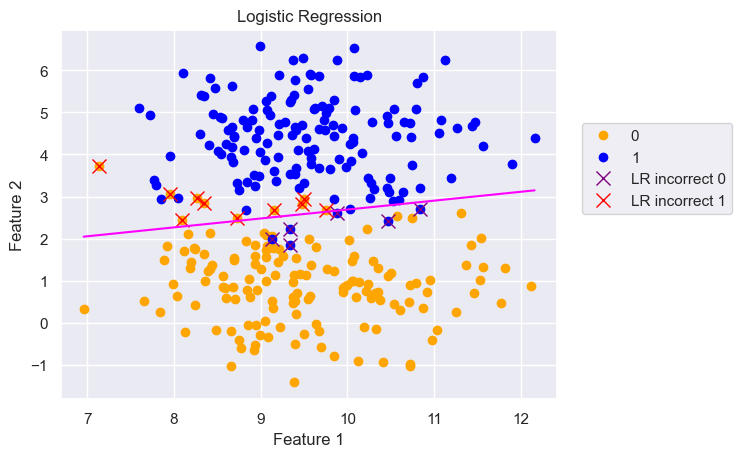

In [6]:
# Plot results

# plot data points with true labels
plt.plot(X[k0,0], X[k0,1], 'o', color='orange', label='0')
plt.plot(X[k1,0], X[k1,1], 'o', color='blue', label='1')

# plot predictions, including wrong ones
j0 = (ymodel==0) & (y==1)
j1 = (ymodel==1) & (y==0)
plt.plot(X[j0,0], X[j0,1], 'x', color='purple', markersize=10, label='LR incorrect 0')
plt.plot(X[j1,0], X[j1,1], 'x', color='red', markersize=10, label='LR incorrect 1')

# plot decision boundary
plt.plot(xx, yy_lr, "-", color="fuchsia")

# clean up plot
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression')
plt.legend(loc=(1.05, 0.5));

## Decision Trees

A decision tree is a flowchart-like structure in which each internal node represents a “test” or "question" on/about a data feature, each branch represents the outcome of the test/question (yes/no), and each leaf node represents a class label. The paths from root to leaf represent classification rules. 

This type of ML model mimics in some ways how humans make decisions, for example for whether or not one might accept a new job offer. In this example, we could think of "salary", "commute time", etc., as analogous to ML features, and the decision in the leaf nodes as analogous to ML predictions.

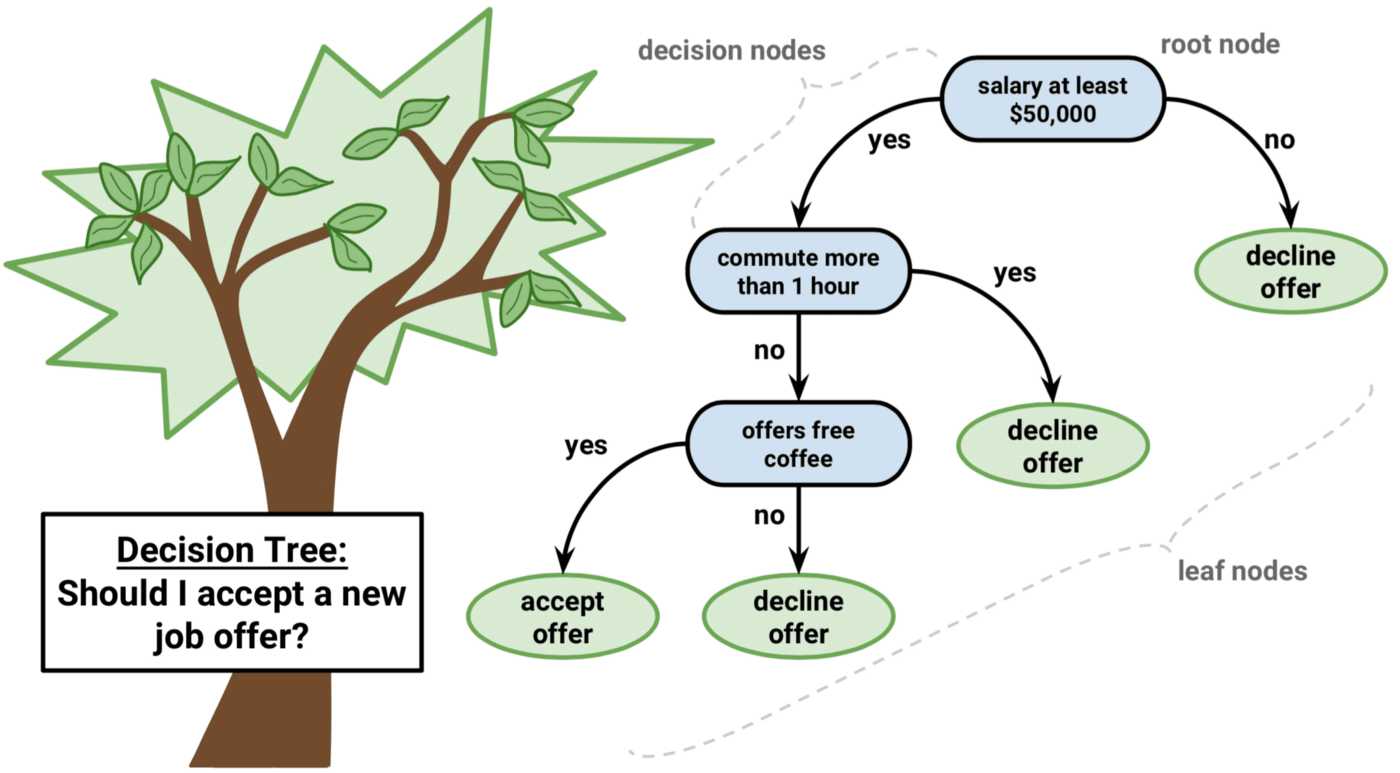

https://medium.datadriveninvestor.com/decision-trees-lesson-101-f00dad6cba21

In [7]:
# Make a new dataset and plot it
X, y = make_moons(n_samples=200, noise=0.25, random_state=3)

# We'll use these later for plotting regions within our data
eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps

# Gridded data points
xx = np.linspace(x_min, x_max, 1000)
yy = np.linspace(y_min, y_max, 1000)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

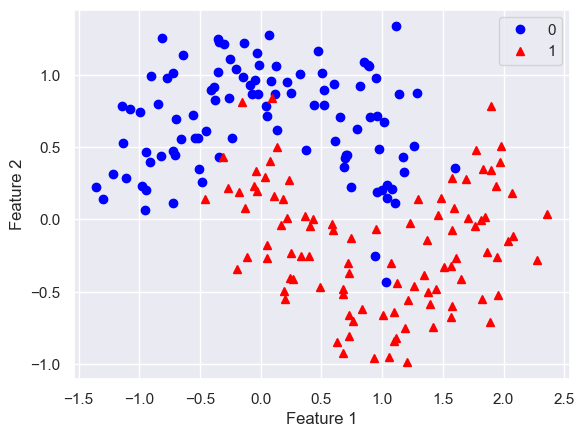

In [8]:
# Plot the data
k0 = y == 0
k1 = y == 1
plt.plot(X[k0,0], X[k0,1], 'o', color='blue', label='0')
plt.plot(X[k1,0], X[k1,1], '^', color='red', label='1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best');

### The simplest decision tree: tree depth = 1

Mathematically, decision trees "slice" the data into different regions of feature space, with each region having its own predicted value (a class label or a number). 

In the simplest case, the tree depth is one, and we ask only a single question about our data. This results in a single slice in feature space.

In [9]:
# Divide into training and testing (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [10]:
# Fit model to training data
#   max_depth = 1 - look only at first branching level
tree = DecisionTreeClassifier(max_depth=1, random_state=0).fit(X_train, y_train) 

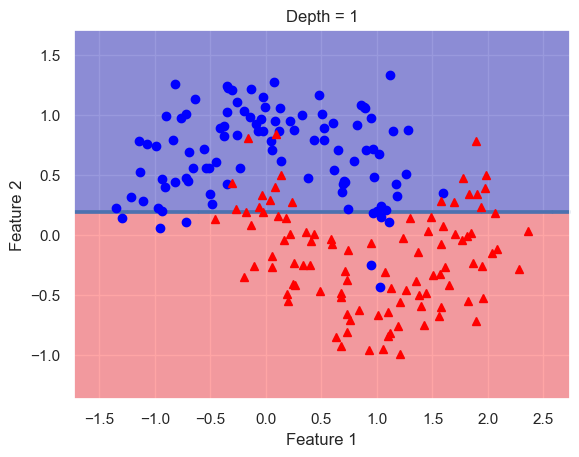

In [11]:
# Plot results

# plot data points
k0 = y == 0
k1 = y == 1
plt.plot(X[k0,0], X[k0,1], 'o', label='0', color='blue')
plt.plot(X[k1,0], X[k1,1], '^', label='1', color='red')

# get predictions for full feature space
Z = tree.predict(X_grid).reshape(X1.shape)
border = ndimage.laplace(Z) != 0 # handy way of finding discontinuities

# plot splits in feature space
cm2 = ListedColormap(['#0000aa', '#ff2020']) # a custom cmap
plt.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
plt.scatter(X1[border], X2[border], marker='.', s=1)

# formatting
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.title('Depth = 1');

### Depth = 2 --> two levels of slices


In [12]:
# Fit model to training data
#   max_depth = 2 - look only at first two branching levels
tree = DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_train, y_train) 

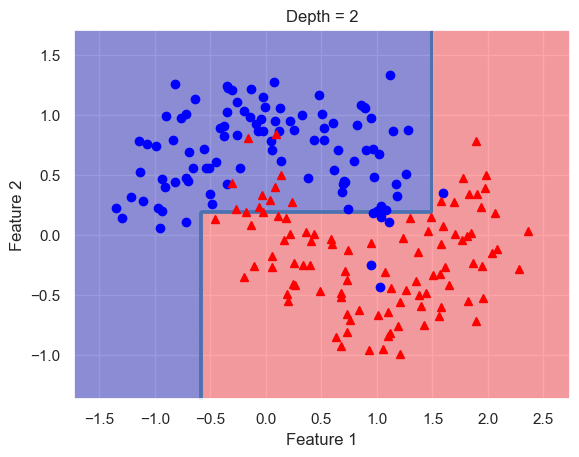

In [13]:
# Plot results

# plot data points
k0 = y==0
k1 = y==1
plt.plot(X[k0,0], X[k0,1], 'o', label='0', color='blue')
plt.plot(X[k1,0], X[k1,1], '^', label='1', color='red')

# get predictions for full feature space
Z = tree.predict(X_grid).reshape(X1.shape)
border = ndimage.laplace(Z) != 0 # handy way of finding discontinuities

# plot splits in feature space
cm2 = ListedColormap(['#0000aa', '#ff2020']) # a custom cmap
plt.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
plt.scatter(X1[border], X2[border], marker='.', s=1)

# formatting
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.title('Depth = 2');

### Depth = 5

In [14]:
# Fit model to training data
#   max_depth = 2 - look only at first two branching levels
tree = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X_train, y_train) 

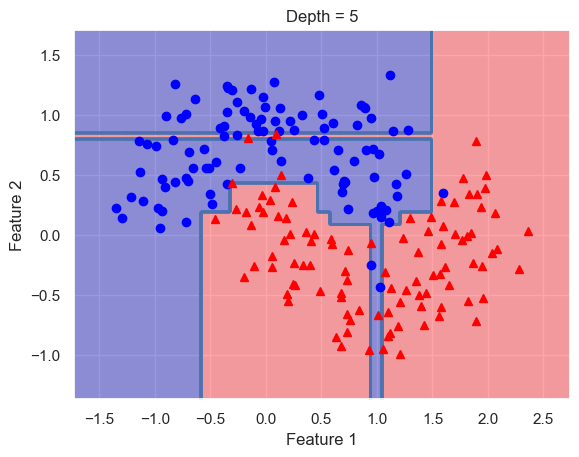

In [15]:
# Plot results

# plot data points
k0 = y==0
k1 = y==1
plt.plot(X[k0,0], X[k0,1], 'o', label='0', color='blue')
plt.plot(X[k1,0], X[k1,1], '^', label='1', color='red')

# get predictions for full feature space
Z = tree.predict(X_grid).reshape(X1.shape)
border = ndimage.laplace(Z) != 0 # handy way of finding discontinuities

# plot splits in feature space
cm2 = ListedColormap(['#0000aa', '#ff2020']) # a custom cmap
plt.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
plt.scatter(X1[border], X2[border], marker='.', s=1)

# formatting
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.title('Depth = 5');

## Random Forest 

Random Forests are essentially a collection of decision trees, where each tree is slightly different from the others. Random Forests get their name from injecting randomness into the tree building to ensure each tree is different. We can then reduce the tendency for "deep" trees to overfit by averaging the results of multiple trees.

There are 2 ways in which the trees are randomized: by selecting the data points used to build a tree, and by selecting the features in each split test. 
* *Data point selection* by bootstrap resampling. Repeatedly draw data points randomly to reach size of original dataset - some will be repeated and some will be excluded.
* *Feature selection* of the number of features that each split can look at. This only introduces randomness if this number is less than the full number of features.

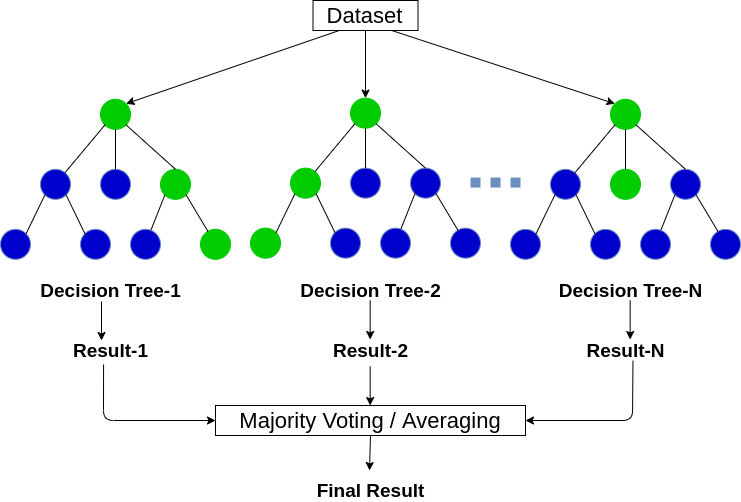

In [16]:
# We include the parameter stratify = y to preserve 
#  the same proportions of examples in each class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


#### Some Random Forest parameters to consider, there are many more
* `n_estimators` = number of trees in the forest
* `max_depth` = the maximum depth of the tree (default = None - keep expanding until leaves are 'pure')
* `min_samples_split` = minimum number of samples to split a node (default = 2)
* `max_features` = number of features to consider when making split (default = 'auto' = sqrt(n_features))
* `bootstrap = True` or `False` = if False all samples are used to build tree (default = True)

In [17]:
# Fit model to training data 
forest = RandomForestClassifier(n_estimators=8, random_state=2) # usually, use more than 8
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=8, random_state=2)

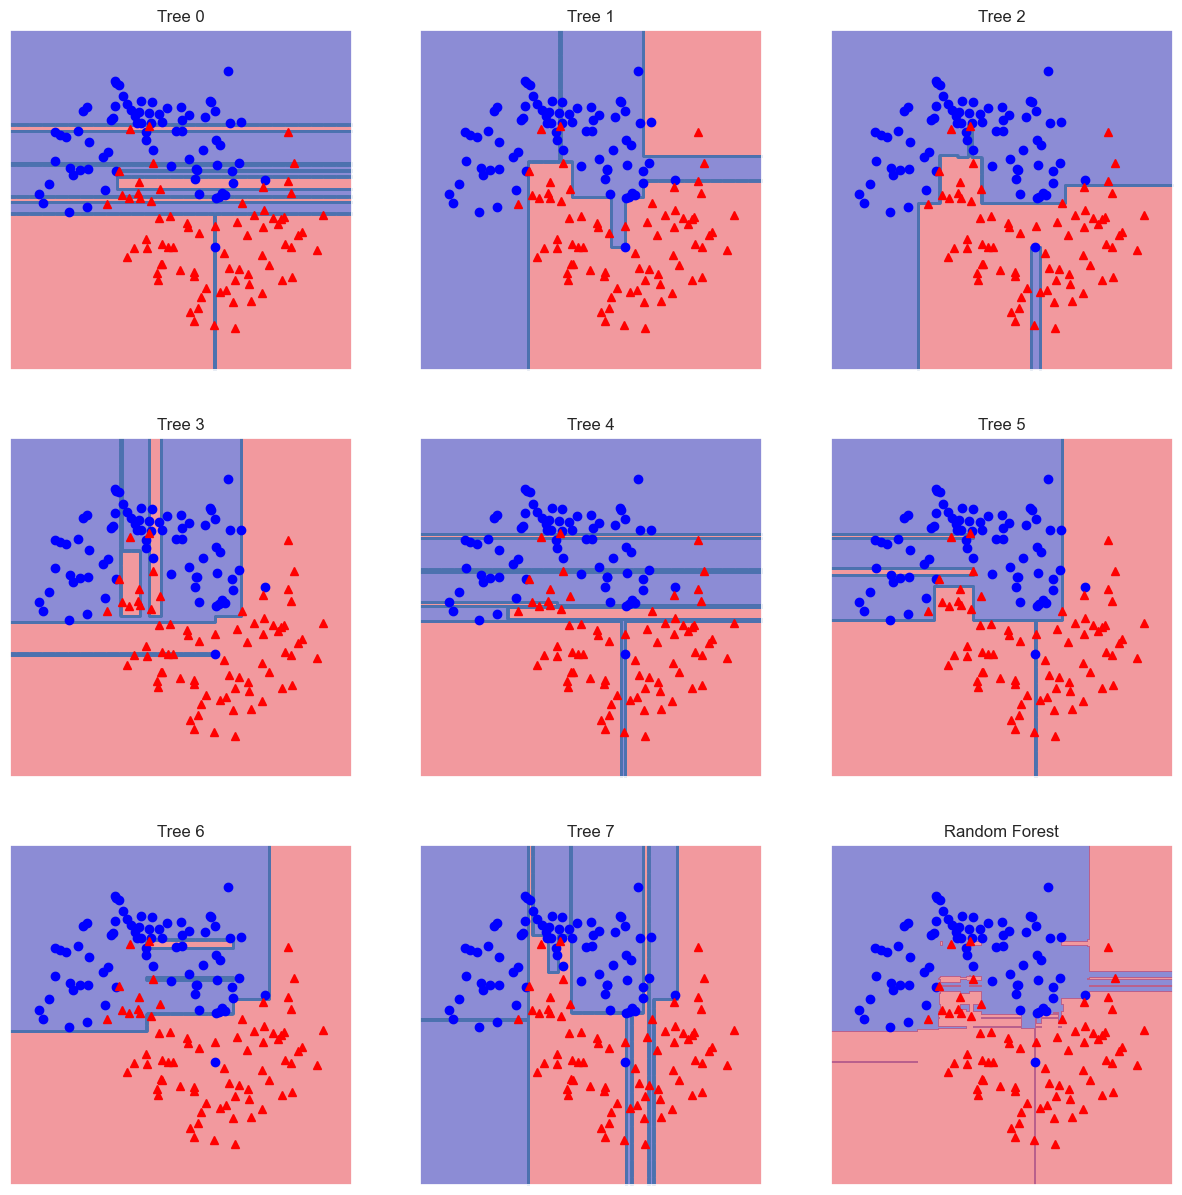

In [18]:
### Plot all trees
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# labels
k0 = y_train == 0
k1 = y_train == 1

# plot each tree individually
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    
    # setup plotting grid
    eps = X_train.std() / 2.
    x_min, x_max = X_train[:, 0].min() - eps, X_train[:, 0].max() + eps
    y_min, y_max = X_train[:, 1].min() - eps, X_train[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)
    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    
    # make predictions and plot, including boundaries
    Z = tree.predict(X_grid).reshape(X1.shape)
    border = ndimage.laplace(Z) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)
    
    # plot data points
    ax.plot(X_train[k0,0], X_train[k0,1], 'o', label='0', color='blue')
    ax.plot(X_train[k1,0], X_train[k1,1], '^', label='1', color='red')
    
    # labeling
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title("Tree {}".format(i))

# plot the results for the random forest itself
ax=axes[-1, -1]
decision_values_rf = forest.predict(X_grid)
fill_levels = [0] + [0.5] + [1]
ax.contourf(X1, X2, decision_values_rf.reshape(X1.shape),
            levels=fill_levels, alpha=0.4, cmap=cm2)
ax.plot(X_train[k0,0], X_train[k0,1], 'o', label='0', color='blue')
ax.plot(X_train[k1,0], X_train[k1,1], '^', label='1', color='red')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Random Forest");

### Random Forests can also provide information about *feature importance*: how useful is each variable in making the final prediction? 

This analysis is based on how different features contribute to decrease in impurity of the predictions from the fitted model. Note that while the impurity-based metrics provided by `scikit-learn` are useful approximations, there are more robust and precise techniques available (e.g., SHAP) if needed.

As an example, let's consider the 'iris' (flower) dataset from `seaborn`. 

In [19]:
# Set up the Iris dataset
iris = sns.load_dataset('iris')
X_iris = iris.drop('species', axis=1)
y_iris = iris['species']

# train/test split (70-30)
Xtrain_iris, Xtest_iris, ytrain_iris, ytest_iris = train_test_split(X_iris, y_iris, test_size=0.3, random_state=50)

In [20]:
# Get the model, fit and predict
irismodel_rf = RandomForestClassifier(n_estimators=500) # usually, 100+
y_model_iris_rf = irismodel_rf.fit(Xtrain_iris, ytrain_iris).predict(Xtest_iris)

# accuracy = fraction of correct classifications
accuracy_score(ytest_iris, y_model_iris_rf)

0.9555555555555556

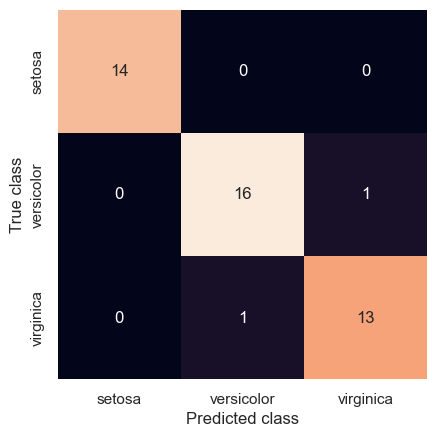

In [21]:
# Plot the confusion matrix
mat2 = confusion_matrix(ytest_iris, y_model_iris_rf)
sns.heatmap(mat2, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=y_iris.unique(), yticklabels=y_iris.unique())
plt.xlabel("Predicted class")
plt.ylabel("True class");

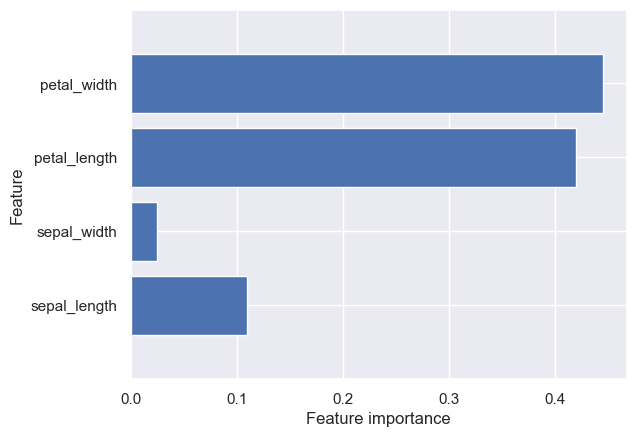

In [22]:
# Plot the feature importance
n_features = irismodel_rf.n_features_in_
plt.barh(np.arange(n_features), irismodel_rf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_iris.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features);

## Regression: models that predict a continuous number. 

For example, predict a person's annual income (the target variable) from their education, age, and where they live (features). 

### The function `r2_score` is a measure of how well a regression model predicts the target vector. The best value is 1.0. 

This comes from $R^2$ in statistics, a measure of the fraction of the variance in the data explained by the model.

In [23]:
# Example using r-squared: perfect
y_true = [1, 2, 3]
y_pred = [1, 2, 3]
print(r2_score(y_true, y_pred))

1.0


In [24]:
# Example using r-squared: random
y_true = [1, 2, 3]
y_pred = [2, 2, 2]
print(r2_score(y_true, y_pred))

0.0


In [25]:
# Example using r-squared: would be better guessing at random
y_true = [1, 2, 3]
y_pred = [3, 2, 1]
print(r2_score(y_true, y_pred))

-3.0


### The diabetes dataset

In [26]:
# Load dataset
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [27]:
# Setup data for ML

# data and target
X_diabetes = diabetes.data
y_diabetes = diabetes.target

# train/test split (70/30)
Xtrain_diabetes, Xtest_diabetes, ytrain_diabetes, ytest_diabetes = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=0)

In [28]:
# target is a quantitative measure of disease progression one year after baseline
df_diabetes = pd.DataFrame(X_diabetes, columns=diabetes.feature_names)
df_diabetes['target'] = y_diabetes
df_diabetes.head() 

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Linear Regression
Linear Regression, or ordinary least squares, is the simplest and most traditional linear method for regression. Linear regression finds model coefficients that linearly combine the input features in order to minimize the mean squared differences between predictions and the true regression targets.

In 1D, this is just fitting a line to the data. In higher dimensions, we are fitting a hyperplane.

In [29]:
# fit model to training data, apply to test
model_lr = LinearRegression(fit_intercept=True)
ymodel_lr = model_lr.fit(Xtrain_diabetes, ytrain_diabetes).predict(Xtest_diabetes)

# print results
print(r2_score(ytest_diabetes,ymodel_lr))
df_diabetes['predicted_lr'] = model_lr.predict(X_diabetes)

0.39289927216962905


If the features are properly normalized, the size of the coefficients gives a measure of feature importance.

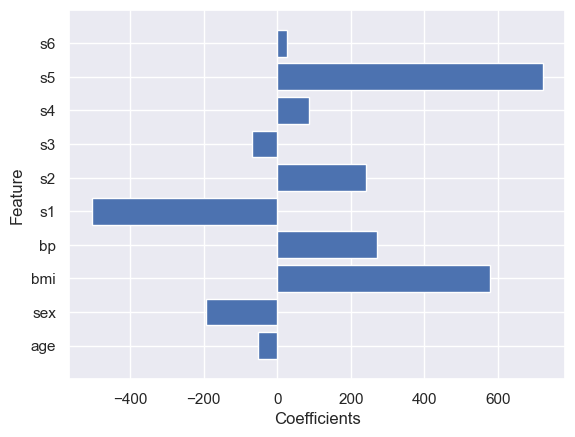

In [30]:
# Plot the coefficients
n_features=10
plt.barh(np.arange(n_features), model_lr.coef_, align='center')
plt.yticks(np.arange(n_features), diabetes.feature_names)
plt.xlabel("Coefficients")
plt.ylabel("Feature")
plt.ylim(-1, n_features);

Note: not all "important" variables are strongly correlated with the target.

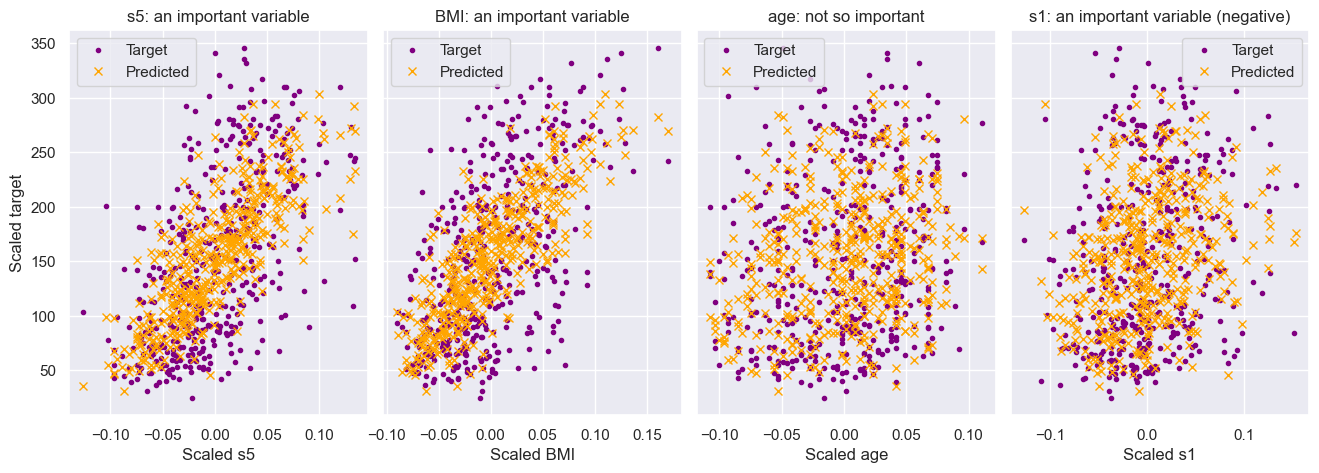

In [31]:
### Compare model predictions with data

# subplot setup
fig, axi = plt.subplots(1,4,figsize=(16,5),sharey=True)
fig.subplots_adjust(wspace=0.05)

# s5 variable
axi[0].plot(df_diabetes['s5'], df_diabetes['target'], '.', color='purple', label='Target')
axi[0].plot(df_diabetes['s5'], df_diabetes['predicted_lr'], 'x', color='orange', label='Predicted')
axi[0].set_xlabel('Scaled s5')
axi[0].set_ylabel('Scaled target')
axi[0].legend(loc='best')
axi[0].set_title('s5: an important variable')

# BMI variable
axi[1].plot(df_diabetes['bmi'], df_diabetes['target'], '.', color='purple', label='Target')
axi[1].plot(df_diabetes['bmi'], df_diabetes['predicted_lr'], 'x', color='orange', label='Predicted')
axi[1].set_xlabel('Scaled BMI')
axi[1].legend(loc='best')
axi[1].set_title('BMI: an important variable')

# age variable
axi[2].plot(df_diabetes['age'], df_diabetes['target'], '.', color='purple', label='Target')
axi[2].plot(df_diabetes['age'], df_diabetes['predicted_lr'], 'x', color='orange', label='Predicted')
axi[2].set_xlabel('Scaled age')
axi[2].legend(loc='best')
axi[2].set_title('age: not so important')

# s1 variable
axi[3].plot(df_diabetes['s1'], df_diabetes['target'], '.', color='purple', label='Target')
axi[3].plot(df_diabetes['s1'], df_diabetes['predicted_lr'], 'x', color='orange', label='Predicted')
axi[3].set_xlabel('Scaled s1')
axi[3].legend(loc='best')
axi[3].set_title('s1: an important variable (negative)');

### K-neighbors regression
K-neighbors regression uses k-nearest neighbors (in the training) to predict values for a sample data point. This is very similar to the classification version we saw in the previous lecture.

In [32]:
# Fit model to training data, evaluate testing performance
model_knn = KNeighborsRegressor(n_neighbors = 3)
ymodel_knn = model_knn.fit(Xtrain_diabetes, ytrain_diabetes).predict(Xtest_diabetes)
print(r2_score(ytest_diabetes, ymodel_knn))

# Add predictions for all data points
df_diabetes["predicted_knn"] =model_knn.predict(X_diabetes)

0.20606948137763026


### Random Forest

In [33]:
# Fit model to training data, evaluate testing performance
model_rf = RandomForestRegressor(max_depth=3, n_estimators=500)
ymodel_rf = model_rf.fit(Xtrain_diabetes, ytrain_diabetes).predict(Xtest_diabetes)
print(r2_score(ytest_diabetes, ymodel_rf))

# Add prediction for all data points
df_diabetes["predicted_rf"] = model_rf.predict(X_diabetes)

0.33676062472257473


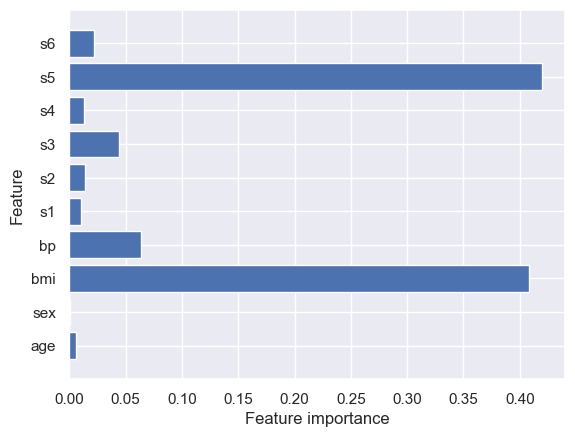

In [34]:
# Plot the feature importance
n_features=model_rf.n_features_in_
plt.barh(np.arange(n_features), model_rf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), diabetes.feature_names)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features);

### Which did the best?

Here, we actually did best with the classical approach (linear regression). This is actually good news, as our model will be easier to interpret. Sometimes, you don't need Machine Learning at all!

In [35]:
print('Linear Regression r2_score = {:4.2f}'.format(r2_score(ytest_diabetes, ymodel_lr)))
print('K Neighbors Regression r2_score = {:4.2f}'.format(r2_score(ytest_diabetes, ymodel_knn)))
print('Random Forest Regression r2_score = {:4.2f}'.format(r2_score(ytest_diabetes, ymodel_rf)))

Linear Regression r2_score = 0.39
K Neighbors Regression r2_score = 0.21
Random Forest Regression r2_score = 0.34


# Summary
* Logistic regression: a "classical" statistical method to classify data by finding a linear decision boundary in a transformed space.
* Decision trees: conceptually simple models that slice up feature space and assign predictions to each decision leaf.
* Random forests: collections of randomized decision trees.
* Decision trees, RFs, KNN models can apply to classification problems (with categorical targets) or regression problems (with quantitative targets).
* In all models, hyperparameters can influence performance.
* Sometimes simpler models are better: use a simple model if you can.